# Cell 1: Install Required Packages
This cell installs all the necessary Python packages for the notebook, including pandas, numpy, matplotlib, seaborn, scikit-learn, imbalanced-learn, and scipy. These libraries are essential for data manipulation, visualization, machine learning, and statistical analysis used throughout the experiments.

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn scipy -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Cell 2: Import Libraries and Set Configuration
This cell imports all the required Python libraries for data processing, machine learning, oversampling, and statistical analysis. It also sets up a configuration dictionary (`CONFIG`) that defines key parameters such as random seed, cross-validation folds, SMOTE k-neighbors range, and other experiment settings.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
import warnings
from sklearn.datasets import load_breast_cancer, load_wine, make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_score, recall_score,
    matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from scipy.stats import ttest_rel, shapiro, wilcoxon, bootstrap
from statsmodels.stats.multitest import multipletests
import time
import io
import requests
warnings.filterwarnings('ignore')

# Enhanced Configuration
CONFIG = {
    'random_state': 42,
    'cv_folds': 5,
    'smote_k_neighbors_range': [3, 5, 7],  # For sensitivity analysis
    'rf_n_estimators': 100,
    'lr_max_iter': 2000,
    'svm_kernel': 'rbf',
    'statistical_alpha': 0.05,
    'min_minority_samples': 10,
    'bootstrap_samples': 1000,
    'confidence_level': 0.95
}

# Cell 3: Ensure Reproducibility
Defines a function to set random seeds for reproducibility and prints out the environment information, including versions of key libraries. This helps ensure that experiments can be repeated with the same results.

In [4]:
def ensure_reproducibility():
    """Set all random seeds for reproducibility"""
    np.random.seed(CONFIG['random_state'])
    random.seed(CONFIG['random_state'])

    # Log environment info
    import sklearn, imblearn, pandas, numpy
    print(f"Enhanced SMOTE Evaluation Framework v2.0")
    print(f"=" * 60)
    print(f"Environment Info:")
    print(f"Python: {sys.version.split()[0]}")
    print(f"NumPy: {numpy.__version__}")
    print(f"Pandas: {pandas.__version__}")
    print(f"Scikit-learn: {sklearn.__version__}")
    print(f"Imbalanced-learn: {imblearn.__version__}")
    print("-" * 60)

# Cell 4: Create Synthetic Dataset
Defines a function to generate a synthetic, high-dimensional, and imbalanced dataset for testing. This is useful for simulating challenging scenarios for oversampling methods.

In [5]:
def create_synthetic_dataset(n_samples=2000, n_features=50, imbalance_ratio=10):
    """Create synthetic high-dimensional dataset for testing"""
    minority_samples = int(n_samples / (imbalance_ratio + 1))
    majority_samples = n_samples - minority_samples

    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=int(n_features * 0.7),
        n_redundant=int(n_features * 0.2),
        n_clusters_per_class=2,
        weights=[majority_samples/n_samples, minority_samples/n_samples],
        flip_y=0.01,
        random_state=CONFIG['random_state']
    )

    return pd.DataFrame(X), pd.Series(y)

# Cell 5: Load Online Dataset
Defines a function to load a dataset from a URL, handle missing values, encode categorical features, and validate class distribution. This function is robust for loading real-world datasets for evaluation.

In [6]:
def load_online_dataset(url, target_col, sep=',', positive_class_condition=None):
    """Load dataset from URL with error handling"""
    try:
        df = pd.read_csv(url, sep=sep)

        if df.empty:
            raise ValueError("Dataset is empty")
        if target_col not in df.columns:
            raise ValueError(f"Missing '{target_col}' column")

        # Handle missing values
        if df.isnull().sum().sum() > 0:
            print(f"Warning: Found {df.isnull().sum().sum()} missing values, filling with median/mode")
            for col in df.columns:
                if df[col].dtype in ['float64', 'int64']:
                    df[col] = df[col].fillna(df[col].median())
                else:
                    df[col] = df[col].fillna(df[col].mode()[0])

        X = df.drop(target_col, axis=1)
        y = df[target_col]

        # Apply positive class condition if provided
        if positive_class_condition is not None:
            y = positive_class_condition(y).astype(int)

        # Encode non-numeric features
        for col in X.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))

        # Validate class distribution
        class_counts = y.value_counts()
        if len(class_counts) != 2:
            raise ValueError("Dataset doesn't have exactly 2 classes")
        if min(class_counts) < CONFIG['min_minority_samples']:
            raise ValueError("Insufficient samples in minority class")

        return X, y

    except Exception as e:
        raise ValueError(f"Failed to load dataset from {url}: {e}")

# Cell 6: Characterize Dataset
Defines a function to analyze and summarize dataset characteristics, including sample size, feature types, imbalance ratio, and complexity metrics. This is used for reporting and understanding the datasets used in the experiments.

In [7]:
def characterize_dataset(X, y, dataset_name):
    """Comprehensive dataset analysis for research paper"""
    char = {
        'name': dataset_name,
        'n_samples': len(X),
        'n_features': X.shape[1],
        'imbalance_ratio': max(y.value_counts()) / min(y.value_counts()),
        'minority_class_size': min(y.value_counts()),
        'majority_class_size': max(y.value_counts())
    }

    # Feature analysis
    char['n_numerical'] = X.select_dtypes(include=[np.number]).shape[1]
    char['n_categorical'] = X.select_dtypes(exclude=[np.number]).shape[1]
    char['missing_values'] = X.isnull().sum().sum()

    # Complexity measures
    if X.shape[1] > 1:
        corr_matrix = X.corr().abs()
        char['feature_correlation_max'] = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool)).max().max()
    else:
        char['feature_correlation_max'] = 0
    char['dimensionality_ratio'] = X.shape[1] / X.shape[0]

    # Dataset complexity metrics
    char['effective_dimensionality'] = estimate_effective_dimensionality(X)
    char['class_separability'] = estimate_class_separability(X, y)

    return char

# Cell 7: Estimate Effective Dimensionality
Defines a function to estimate the effective dimensionality of a dataset using PCA. This helps in understanding the intrinsic complexity of the data.

In [8]:
def estimate_effective_dimensionality(X, variance_threshold=0.95):
    """Estimate effective dimensionality using PCA variance explained"""
    from sklearn.decomposition import PCA
    try:
        pca = PCA()
        pca.fit(StandardScaler().fit_transform(X))
        cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
        effective_dim = np.argmax(cumsum_variance >= variance_threshold) + 1
        return min(effective_dim, X.shape[1])
    except:
        return X.shape[1]

# Cell 8: Estimate Class Separability
Defines a function to estimate class separability using Fisher's ratio. This metric provides insight into how well the classes can be distinguished in the feature space.

In [9]:
def estimate_class_separability(X, y):
    """Estimate class separability using Fisher's ratio"""
    try:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        class_0 = X_scaled[y == 0]
        class_1 = X_scaled[y == 1]

        if len(class_0) == 0 or len(class_1) == 0:
            return 0

        mean_0 = np.mean(class_0, axis=0)
        mean_1 = np.mean(class_1, axis=0)
        var_0 = np.var(class_0, axis=0)
        var_1 = np.var(class_1, axis=0)

        # Fisher's ratio for each feature
        fisher_ratios = []
        for i in range(X_scaled.shape[1]):
            if var_0[i] + var_1[i] > 0:
                fisher_ratio = (mean_0[i] - mean_1[i])**2 / (var_0[i] + var_1[i])
                fisher_ratios.append(fisher_ratio)

        return np.mean(fisher_ratios) if fisher_ratios else 0
    except:
        return 0

# Cell 9: Load Datasets
Defines a function to load and characterize multiple datasets (Wine Quality, Breast Cancer, Wine (sklearn), Credit Fraud, High-Dimensional Synthetic). It prints dataset statistics and handles errors gracefully.

In [10]:
def load_datasets():
    """Load multiple datasets for comprehensive evaluation"""
    datasets = {}

    # 1. Wine Quality Dataset (Original)
    try:
        X_wine, y_wine = load_online_dataset(
            'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
            'quality',
            sep=';',
            positive_class_condition=lambda x: x >= 7
        )
        datasets['WineQuality'] = (X_wine, y_wine)
        print(f"Wine Quality loaded: {X_wine.shape[0]} samples, {X_wine.shape[1]} features")

        char = characterize_dataset(X_wine, y_wine, 'WineQuality')
        print(f"  Imbalance ratio: {char['imbalance_ratio']:.2f}:1")
        print(f"  Effective dimensionality: {char['effective_dimensionality']}")

    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")

    # 2. Breast Cancer Dataset (Original)
    try:
        breast_data = load_breast_cancer()
        X_breast = pd.DataFrame(breast_data.data, columns=breast_data.feature_names)
        y_breast = pd.Series(breast_data.target)
        datasets['BreastCancer'] = (X_breast, y_breast)
        print(f"Breast Cancer loaded: {X_breast.shape[0]} samples, {X_breast.shape[1]} features")

        char = characterize_dataset(X_breast, y_breast, 'BreastCancer')
        print(f"  Imbalance ratio: {char['imbalance_ratio']:.2f}:1")
        print(f"  Effective dimensionality: {char['effective_dimensionality']}")

    except Exception as e:
        print(f"Error loading Breast Cancer dataset: {e}")

    # 3. Wine Dataset (Multi-class converted to binary)
    try:
        wine_data = load_wine()
        X_wine_sklearn = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
        y_wine_sklearn = pd.Series(wine_data.target)
        # Convert to binary: class 0 vs others
        y_wine_sklearn = (y_wine_sklearn == 0).astype(int)
        datasets['WineSklearn'] = (X_wine_sklearn, y_wine_sklearn)
        print(f"Wine (sklearn) loaded: {X_wine_sklearn.shape[0]} samples, {X_wine_sklearn.shape[1]} features")

        char = characterize_dataset(X_wine_sklearn, y_wine_sklearn, 'WineSklearn')
        print(f"  Imbalance ratio: {char['imbalance_ratio']:.2f}:1")
        print(f"  Effective dimensionality: {char['effective_dimensionality']}")

    except Exception as e:
        print(f"Error loading Wine (sklearn) dataset: {e}")

    # 4. Credit Card Fraud Dataset (if available)
    try:
        # This is a placeholder - in practice you'd load from Kaggle or similar
        # For now, create a synthetic high-dimensional severely imbalanced dataset
        X_fraud, y_fraud = create_synthetic_dataset(n_samples=2000, n_features=28, imbalance_ratio=20)
        datasets['CreditFraud'] = (X_fraud, y_fraud)
        print(f"Credit Fraud (synthetic) loaded: {X_fraud.shape[0]} samples, {X_fraud.shape[1]} features")

        char = characterize_dataset(X_fraud, y_fraud, 'CreditFraud')
        print(f"  Imbalance ratio: {char['imbalance_ratio']:.2f}:1")
        print(f"  Effective dimensionality: {char['effective_dimensionality']}")

    except Exception as e:
        print(f"Error creating Credit Fraud dataset: {e}")

    # 5. High-Dimensional Synthetic Dataset
    try:
        X_highdim, y_highdim = create_synthetic_dataset(n_samples=1500, n_features=100, imbalance_ratio=8)
        datasets['HighDim'] = (X_highdim, y_highdim)
        print(f"High Dimensional loaded: {X_highdim.shape[0]} samples, {X_highdim.shape[1]} features")

        char = characterize_dataset(X_highdim, y_highdim, 'HighDim')
        print(f"  Imbalance ratio: {char['imbalance_ratio']:.2f}:1")
        print(f"  Effective dimensionality: {char['effective_dimensionality']}")

    except Exception as e:
        print(f"Error creating High Dimensional dataset: {e}")

    return datasets

# Cell 10: Get Safe Oversampler
Defines a function to dynamically create an oversampler (e.g., SMOTE, ADASYN) based on the training data, ensuring the k-neighbors parameter is always valid for the current fold.

In [11]:
def get_safe_oversampler(oversampler_name, y_train, random_state, k_neighbors=None):
    """Dynamically create oversampler based on training data only"""
    minority_count = min(y_train.value_counts())

    if k_neighbors is None:
        safe_k = max(1, min(CONFIG['smote_k_neighbors_range'][1], minority_count - 1))
    else:
        safe_k = max(1, min(k_neighbors, minority_count - 1))

    oversamplers = {
        "RandomOver": RandomOverSampler(random_state=random_state),
        "SMOTE": SMOTE(random_state=random_state, k_neighbors=safe_k),
        "BorderlineSMOTE": BorderlineSMOTE(random_state=random_state, k_neighbors=safe_k),
        "ADASYN": ADASYN(random_state=random_state, n_neighbors=safe_k),
        "SMOTETomek": SMOTETomek(random_state=random_state,
                                smote=SMOTE(k_neighbors=safe_k, random_state=random_state)),
        "SMOTEENN": SMOTEENN(random_state=random_state,
                            smote=SMOTE(k_neighbors=safe_k, random_state=random_state))
    }

    return oversamplers.get(oversampler_name)

# Cell 11: Create Classifiers
Defines a function to instantiate several classifiers (Random Forest, Logistic Regression, SVM, Balanced Random Forest, MLP) with research-appropriate parameters for use in the experiments.

In [12]:
def create_classifiers():
    """Create classifier instances with research-appropriate parameters"""
    return {
        "RandomForest": RandomForestClassifier(
            n_estimators=CONFIG['rf_n_estimators'],
            random_state=CONFIG['random_state'],
            n_jobs=-1
        ),
        "LogisticRegression": LogisticRegression(
            max_iter=CONFIG['lr_max_iter'],
            random_state=CONFIG['random_state']
        ),
        "SVM": SVC(
            kernel=CONFIG['svm_kernel'],
            probability=True,
            random_state=CONFIG['random_state']
        ),
        "BalancedRF": RandomForestClassifier(
            n_estimators=CONFIG['rf_n_estimators'],
            class_weight='balanced',
            random_state=CONFIG['random_state'],
            n_jobs=-1
        ),
        "MLP": MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=500,
            random_state=CONFIG['random_state']
        )
    }

# Cell 12: Calculate Confidence Interval
Defines a function to compute bootstrap confidence intervals for performance scores, providing statistical uncertainty estimates for the results.

In [13]:
def calculate_confidence_interval(scores, confidence_level=None):
    """Calculate bootstrap confidence interval for performance scores"""
    if confidence_level is None:
        confidence_level = CONFIG['confidence_level']

    if len(scores) < 2:
        return np.nan, np.nan

    try:
        # Bootstrap resampling
        bootstrap_samples = []
        for _ in range(CONFIG['bootstrap_samples']):
            resample = np.random.choice(scores, size=len(scores), replace=True)
            bootstrap_samples.append(np.mean(resample))

        alpha = 1 - confidence_level
        lower_percentile = (alpha/2) * 100
        upper_percentile = (1 - alpha/2) * 100

        ci_lower = np.percentile(bootstrap_samples, lower_percentile)
        ci_upper = np.percentile(bootstrap_samples, upper_percentile)

        return ci_lower, ci_upper
    except:
        return np.nan, np.nan

# Cell 13: Evaluate Single Fold
Defines a function to evaluate a single cross-validation fold, including oversampling, model training, prediction, and metric calculation. Handles errors and records training time.

In [14]:
def evaluate_single_fold(X_train, X_test, y_train, y_test, oversampler_name, classifier_name, classifier, fold_num, k_neighbors=None):
    """Evaluate a single fold with proper error handling and timing"""
    start_time = time.time()

    try:
        # Create pipeline
        if oversampler_name == "No_Oversampling":
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', classifier)
            ])
        else:
            # Get oversampler for this specific training set
            oversampler = get_safe_oversampler(oversampler_name, y_train, CONFIG['random_state'], k_neighbors)
            if oversampler is None:
                return None

            pipeline = ImbPipeline([
                ('scaler', StandardScaler()),
                ('oversampler', oversampler),
                ('classifier', classifier)
            ])

        # Fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Get probabilities if available
        if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
        else:
            y_proba = y_pred.astype(float)

        # Calculate metrics
        metrics = {
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'kappa': cohen_kappa_score(y_test, y_pred),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'training_time': time.time() - start_time,
            'samples_generated': len(y_train) if oversampler_name == "No_Oversampling" else "unknown"
        }

        return metrics

    except Exception as e:
        print(f"Error in fold {fold_num} for {oversampler_name}+{classifier_name}: {e}")
        return None

# Cell 14: Sensitivity Analysis for k-Neighbors
Defines a function to perform sensitivity analysis on the k-neighbors parameter for SMOTE, evaluating its effect on F1 score across different values and folds.

In [15]:
def sensitivity_analysis_k_neighbors(X, y, dataset_name, n_splits=3):
    """Perform sensitivity analysis for k-neighbors parameter"""
    print(f"\n{'='*50}")
    print(f"K-NEIGHBORS SENSITIVITY ANALYSIS - {dataset_name}")
    print(f"{'='*50}")

    k_values = CONFIG['smote_k_neighbors_range']
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CONFIG['random_state'])
    classifier = RandomForestClassifier(n_estimators=50, random_state=CONFIG['random_state'])

    results = []

    for k in k_values:
        fold_scores = []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Check if k is feasible
            minority_count = min(y_train.value_counts())
            if k >= minority_count:
                continue

            result = evaluate_single_fold(
                X_train, X_test, y_train, y_test,
                "SMOTE", "RandomForest", classifier, fold, k_neighbors=k
            )

            if result is not None:
                fold_scores.append(result['f1'])

        if fold_scores:
            mean_f1 = np.mean(fold_scores)
            std_f1 = np.std(fold_scores)
            results.append({
                'k_neighbors': k,
                'mean_f1': mean_f1,
                'std_f1': std_f1,
                'n_folds': len(fold_scores)
            })

            print(f"k={k}: F1 = {mean_f1:.3f} ± {std_f1:.3f} ({len(fold_scores)} folds)")

    return pd.DataFrame(results)

# Cell 15: Evaluate Dataset
Defines a function to evaluate all oversampling techniques and classifiers on a single dataset, including cross-validation, metric calculation, sensitivity analysis, and result aggregation.

In [16]:
def evaluate_dataset(X, y, dataset_name, n_splits=None, include_sensitivity=True):
    """Evaluate oversampling techniques on a single dataset with enhanced analysis"""
    if n_splits is None:
        n_splits = CONFIG['cv_folds']

    print(f"\n{'='*60}")
    print(f"EVALUATING {dataset_name.upper()} DATASET")
    print(f"{'='*60}")

    # Dataset characteristics
    char = characterize_dataset(X, y, dataset_name)
    print(f"Samples: {char['n_samples']}, Features: {char['n_features']}")
    print(f"Imbalance ratio: {char['imbalance_ratio']:.2f}:1")
    print(f"Class distribution: {dict(y.value_counts())}")
    print(f"Effective dimensionality: {char['effective_dimensionality']}")
    print(f"Class separability: {char['class_separability']:.3f}")

    # Sensitivity analysis for k-neighbors
    sensitivity_results = None
    if include_sensitivity and char['imbalance_ratio'] > 2:
        try:
            sensitivity_results = sensitivity_analysis_k_neighbors(X, y, dataset_name)
        except Exception as e:
            print(f"Sensitivity analysis failed: {e}")

    # Define oversampling techniques
    oversampler_names = ["No_Oversampling", "RandomOver", "SMOTE", "BorderlineSMOTE", "ADASYN", "SMOTETomek", "SMOTEENN"]

    # Define classifiers
    classifiers = create_classifiers()

    # Metrics to evaluate
    metrics = ["f1", "roc_auc", "precision", "recall", "balanced_accuracy", "kappa", "mcc"]

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CONFIG['random_state'])

    # Store results
    results = []
    fold_scores = {name: {clf: {metric: [] for metric in metrics} for clf in classifiers}
                   for name in oversampler_names}

    # Main evaluation loop
    total_combinations = len(oversampler_names) * len(classifiers)
    current_combination = 0

    for oversampler_name in oversampler_names:
        print(f"\nTesting {oversampler_name}...")

        for clf_name, classifier in classifiers.items():
            current_combination += 1
            print(f"  Progress: {current_combination}/{total_combinations} - {clf_name}")

            fold_metrics = {metric: [] for metric in metrics}
            fold_metrics['training_time'] = []
            successful_folds = 0

            for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                # Check if minority class has enough samples
                minority_count = min(y_train.value_counts())
                if minority_count < 2 and oversampler_name != "No_Oversampling":
                    continue

                # Evaluate fold
                fold_result = evaluate_single_fold(
                    X_train, X_test, y_train, y_test,
                    oversampler_name, clf_name, classifier, fold
                )

                if fold_result is not None:
                    for metric in metrics:
                        fold_metrics[metric].append(fold_result[metric])
                    fold_metrics['training_time'].append(fold_result['training_time'])
                    successful_folds += 1

            # Store fold scores for statistical testing
            for metric in metrics:
                if fold_metrics[metric]:
                    fold_scores[oversampler_name][clf_name][metric] = fold_metrics[metric]

            # Calculate statistics for this combination
            if successful_folds > 0:
                for metric in metrics:
                    if fold_metrics[metric]:
                        scores = fold_metrics[metric]
                        ci_lower, ci_upper = calculate_confidence_interval(scores)

                        results.append({
                            'Dataset': dataset_name,
                            'Oversampler': oversampler_name,
                            'Classifier': clf_name,
                            'Metric': metric,
                            'Mean': np.mean(scores),
                            'Std': np.std(scores),
                            'CI_Lower': ci_lower,
                            'CI_Upper': ci_upper,
                            'N_folds': len(scores),
                            'Scores': scores
                        })

                # Add timing information
                if fold_metrics['training_time']:
                    results.append({
                        'Dataset': dataset_name,
                        'Oversampler': oversampler_name,
                        'Classifier': clf_name,
                        'Metric': 'training_time',
                        'Mean': np.mean(fold_metrics['training_time']),
                        'Std': np.std(fold_metrics['training_time']),
                        'CI_Lower': np.nan,
                        'CI_Upper': np.nan,
                        'N_folds': len(fold_metrics['training_time']),
                        'Scores': fold_metrics['training_time']
                    })

                print(f"    {clf_name}: {successful_folds}/{n_splits} successful folds")

    return pd.DataFrame(results), fold_scores, sensitivity_results

# Cell 16: Enhanced Statistical Testing
Defines a function to perform advanced statistical testing (paired t-test or Wilcoxon), effect size calculation, and multiple testing correction to compare oversampling methods.

In [17]:
def enhanced_statistical_testing(fold_scores, dataset_name, alpha=None):
    """Enhanced statistical testing with power analysis and effect sizes"""
    if alpha is None:
        alpha = CONFIG['statistical_alpha']

    print(f"\n{'='*70}")
    print(f"ENHANCED STATISTICAL ANALYSIS - {dataset_name}")
    print(f"{'='*70}")

    baseline_name = "No_Oversampling"
    test_methods = ["RandomOver", "SMOTE", "BorderlineSMOTE", "ADASYN", "SMOTETomek", "SMOTEENN"]

    all_results = []

    for clf_name in ["RandomForest", "LogisticRegression", "SVM", "BalancedRF", "MLP"]:
        print(f"\n{clf_name} - F1 Score Analysis:")
        print("-" * 60)

        if (baseline_name not in fold_scores or clf_name not in fold_scores[baseline_name] or
            'f1' not in fold_scores[baseline_name][clf_name] or
            len(fold_scores[baseline_name][clf_name]['f1']) <= 1):
            print("Insufficient baseline data for statistical testing")
            continue

        baseline_scores = np.array(fold_scores[baseline_name][clf_name]['f1'])

        # Test normality of baseline
        if len(baseline_scores) >= 3:
            _, p_normal = shapiro(baseline_scores)
            use_parametric = p_normal > 0.05
        else:
            use_parametric = False

        print(f"Test type: {'Parametric' if use_parametric else 'Non-parametric'}")
        print(f"Baseline performance: {np.mean(baseline_scores):.3f} ± {np.std(baseline_scores):.3f}")

        p_values = []
        method_names = []
        effect_sizes = []

        for method in test_methods:
            if (method not in fold_scores or clf_name not in fold_scores[method] or
                'f1' not in fold_scores[method][clf_name] or
                len(fold_scores[method][clf_name]['f1']) != len(baseline_scores)):
                continue

            method_scores = np.array(fold_scores[method][clf_name]['f1'])

            try:
                # Statistical test
                if use_parametric and len(baseline_scores) > 1:
                    t_stat, p_value = ttest_rel(baseline_scores, method_scores)
                    test_type = 'paired_t_test'
                else:
                    if np.array_equal(baseline_scores, method_scores):
                        p_value = 1.0
                        t_stat = 0.0
                    else:
                        t_stat, p_value = wilcoxon(baseline_scores, method_scores,
                                                 alternative='two-sided', zero_method='zsplit')
                    test_type = 'wilcoxon'

                # Effect size calculations
                pooled_std = np.sqrt((np.var(baseline_scores, ddof=1) +
                                    np.var(method_scores, ddof=1)) / 2)
                if pooled_std > 0:
                    cohens_d = (np.mean(method_scores) - np.mean(baseline_scores)) / pooled_std
                else:
                    cohens_d = 0.0

                # Glass's Delta (alternative effect size)
                baseline_std = np.std(baseline_scores, ddof=1)
                if baseline_std > 0:
                    glass_delta = (np.mean(method_scores) - np.mean(baseline_scores)) / baseline_std
                else:
                    glass_delta = 0.0

                # Practical significance
                min_meaningful_diff = 0.05  # 5% improvement considered meaningful
                practical_significance = abs(np.mean(method_scores) - np.mean(baseline_scores)) >= min_meaningful_diff

                p_values.append(p_value)
                method_names.append(method)
                effect_sizes.append(cohens_d)

                all_results.append({
                    'dataset': dataset_name,
                    'classifier': clf_name,
                    'method': method,
                    'p_value_raw': p_value,
                    'effect_size_cohens_d': cohens_d,
                    'effect_size_glass_delta': glass_delta,
                    'test_statistic': t_stat,
                    'test_type': test_type,
                    'mean_baseline': np.mean(baseline_scores),
                    'mean_method': np.mean(method_scores),
                    'practical_significance': practical_significance,
                    'baseline_std': np.std(baseline_scores),
                    'method_std': np.std(method_scores)
                })

            except Exception as e:
                print(f"Error in statistical test for {method}: {e}")
                continue

        # Apply multiple testing correction
        if p_values:
            try:
                _, p_corrected, _, _ = multipletests(p_values, alpha=alpha, method='holm')

                for i, (method, p_raw, p_corr, cohens_d) in enumerate(zip(method_names, p_values, p_corrected, effect_sizes)):
                    result_idx = len(all_results) - len(p_values) + i
                    all_results[result_idx]['p_value_corrected'] = p_corr
                    all_results[result_idx]['significant'] = p_corr < alpha

                    # Enhanced reporting
                    significance = "***" if p_corr < 0.001 else "**" if p_corr < 0.01 else "*" if p_corr < 0.05 else ""
                    mean_diff = all_results[result_idx]['mean_method'] - all_results[result_idx]['mean_baseline']

                    # Effect size interpretation
                    if abs(cohens_d) < 0.2:
                        effect_interp = "negligible"
                    elif abs(cohens_d) < 0.5:
                        effect_interp = "small"
                    elif abs(cohens_d) < 0.8:
                        effect_interp = "medium"
                    else:
                        effect_interp = "large"

                    practical = " [PRACTICAL]" if all_results[result_idx]['practical_significance'] else ""

                    print(f"{method:15} vs Baseline: "
                          f"p_raw={p_raw:.4f}, p_corr={p_corr:.4f}{significance:3} "
                          f"Δ={mean_diff:+.3f}, d={cohens_d:.3f} ({effect_interp}){practical}")

            except Exception as e:
                print(f"Error in multiple testing correction: {e}")

    return pd.DataFrame(all_results)

# Cell 17: Create Enhanced Visualizations
Defines a function to generate comprehensive visualizations, including F1 score comparisons, statistical significance heatmaps, and training time analysis, saving them as high-quality PNG files.

In [18]:
def create_enhanced_visualizations(results_df, statistical_results_df=None):
    """Create comprehensive visualizations with confidence intervals"""
    plt.style.use('default')
    sns.set_palette("husl")

    # Get unique datasets
    datasets = results_df['Dataset'].unique()
    n_datasets = len(datasets)

    # 1. F1 Performance Comparison with Confidence Intervals
    fig, axes = plt.subplots(1, min(n_datasets, 3), figsize=(6*min(n_datasets, 3), 6))
    if n_datasets == 1:
        axes = [axes]

    for i, dataset in enumerate(datasets[:3]):  # Show up to 3 datasets
        if i >= len(axes):
            break

        data = results_df[(results_df['Dataset'] == dataset) &
                         (results_df['Metric'] == 'f1') &
                         (results_df['Classifier'].isin(['RandomForest', 'LogisticRegression', 'SVM']))]

        if not data.empty:
            # Create bar plot
            sns.barplot(data=data, x='Oversampler', y='Mean',
                       hue='Classifier', ax=axes[i], capsize=0.1, errwidth=2)

            # Add confidence interval error bars
            for j, (_, row) in enumerate(data.iterrows()):
                if not (pd.isna(row['CI_Lower']) or pd.isna(row['CI_Upper'])):
                    # Find the corresponding bar
                    classifier_idx = ['RandomForest', 'LogisticRegression', 'SVM'].index(row['Classifier'])
                    oversampler_idx = list(data['Oversampler'].unique()).index(row['Oversampler'])

                    bar_idx = oversampler_idx * 3 + classifier_idx
                    if bar_idx < len(axes[i].patches):
                        bar = axes[i].patches[bar_idx]
                        axes[i].errorbar(bar.get_x() + bar.get_width()/2, row['Mean'],
                                       yerr=[[row['Mean'] - row['CI_Lower']], [row['CI_Upper'] - row['Mean']]],
                                       capsize=3, color='black', alpha=0.7)

            # Enhanced formatting
            char = characterize_dataset(*datasets_dict[dataset], dataset)
            title = f'{dataset}\n(IR: {char["imbalance_ratio"]:.1f}:1, D: {char["n_features"]})'
            axes[i].set_title(title, fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Oversampling Method', fontsize=10)
            axes[i].set_ylabel('F1 Score', fontsize=10)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title='Classifier', loc='best', fontsize=8)
            axes[i].grid(True, alpha=0.3)
            axes[i].set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig('enhanced_f1_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Statistical Significance Heatmap
    if statistical_results_df is not None and not statistical_results_df.empty:
        fig, axes = plt.subplots(1, min(n_datasets, 2), figsize=(8*min(n_datasets, 2), 6))
        if n_datasets == 1:
            axes = [axes]

        for i, dataset in enumerate(datasets[:2]):
            if i >= len(axes):
                break

            dataset_stats = statistical_results_df[statistical_results_df['dataset'] == dataset]

            if not dataset_stats.empty:
                # Create significance matrix
                pivot_data = dataset_stats.pivot_table(
                    index='method',
                    columns='classifier',
                    values='p_value_corrected',
                    fill_value=1.0
                )

                # Convert p-values to significance levels
                sig_matrix = pivot_data.applymap(lambda x: 3 if x < 0.001 else 2 if x < 0.01 else 1 if x < 0.05 else 0)

                sns.heatmap(sig_matrix, annot=True, cmap='RdYlBu_r',
                           ax=axes[i], cbar_kws={'label': 'Significance Level'},
                           fmt='d')
                axes[i].set_title(f'Statistical Significance - {dataset}')
                axes[i].set_xlabel('Classifier')
                axes[i].set_ylabel('Oversampling Method')

        plt.tight_layout()
        plt.savefig('statistical_significance_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 3. Training Time Analysis
    time_data = results_df[results_df['Metric'] == 'training_time']
    if not time_data.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=time_data, x='Oversampler', y='Mean', hue='Dataset')
        plt.title('Training Time Comparison Across Methods and Datasets')
        plt.xlabel('Oversampling Method')
        plt.ylabel('Training Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('training_time_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

# Cell 18: Create Comprehensive Summary Table
Defines a function to print summary tables for dataset characteristics, F1 scores with confidence intervals, and statistical significance/effect size results for research reporting.

In [19]:
def create_comprehensive_summary_table(results_df, statistical_results_df=None):
    """Create comprehensive summary tables for research paper"""
    print("="*100)
    print("COMPREHENSIVE RESEARCH SUMMARY - ENHANCED ANALYSIS")
    print("="*100)

    # Dataset characteristics table
    print("\nDataset Characteristics:")
    print("-" * 80)
    char_data = []
    for dataset_name in results_df['Dataset'].unique():
        if dataset_name in datasets_dict:
            X, y = datasets_dict[dataset_name]
            char = characterize_dataset(X, y, dataset_name)
            char_data.append(char)

    char_df = pd.DataFrame(char_data)
    print(char_df.to_string(index=False))

    # F1 Score summary with confidence intervals
    print(f"\n{'='*100}")
    print("F1 SCORE SUMMARY WITH 95% CONFIDENCE INTERVALS")
    print(f"{'='*100}")

    for dataset in results_df['Dataset'].unique():
        print(f"\n{dataset}:")
        print("-" * 80)
        dataset_data = results_df[(results_df['Dataset'] == dataset) & (results_df['Metric'] == 'f1')]

        if not dataset_data.empty:
            # Create summary table
            summary_table = []
            for oversampler in dataset_data['Oversampler'].unique():
                row = {'Method': oversampler}
                ovsamp_data = dataset_data[dataset_data['Oversampler'] == oversampler]

                for classifier in ['RandomForest', 'LogisticRegression', 'SVM']:
                    clf_data = ovsamp_data[ovsamp_data['Classifier'] == classifier]
                    if not clf_data.empty:
                        mean_val = clf_data['Mean'].iloc[0]
                        ci_lower = clf_data['CI_Lower'].iloc[0]
                        ci_upper = clf_data['CI_Upper'].iloc[0]

                        if pd.isna(ci_lower) or pd.isna(ci_upper):
                            row[classifier] = f"{mean_val:.3f}"
                        else:
                            row[classifier] = f"{mean_val:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]"
                    else:
                        row[classifier] = "N/A"

                summary_table.append(row)

            summary_df = pd.DataFrame(summary_table)
            print(summary_df.to_string(index=False))

    # Statistical significance summary
    if statistical_results_df is not None and not statistical_results_df.empty:
        print(f"\n{'='*100}")
        print("STATISTICAL SIGNIFICANCE AND EFFECT SIZE SUMMARY")
        print(f"{'='*100}")

        sig_summary = statistical_results_df.groupby(['dataset', 'classifier']).agg({
            'significant': 'sum',
            'method': 'count',
            'effect_size_cohens_d': lambda x: np.mean(np.abs(x))
        }).reset_index()
        sig_summary['sig_ratio'] = sig_summary['significant'] / sig_summary['method']
        sig_summary = sig_summary.round(3)

        print(sig_summary.to_string(index=False))

        # Detailed significant results
        significant_results = statistical_results_df[statistical_results_df['significant'] == True]
        if not significant_results.empty:
            print(f"\n{'='*80}")
            print("DETAILED SIGNIFICANT RESULTS")
            print(f"{'='*80}")

            for _, row in significant_results.iterrows():
                print(f"{row['dataset']} - {row['classifier']} - {row['method']}:")
                print(f"  p-value (corrected): {row['p_value_corrected']:.4f}")
                print(f"  Effect size (Cohen's d): {row['effect_size_cohens_d']:.3f}")
                print(f"  Mean improvement: {row['mean_method'] - row['mean_baseline']:+.3f}")
                print(f"  Practical significance: {row['practical_significance']}")
                print()

# Cell 19: Main Execution Function
Defines the main function that orchestrates the entire experimental pipeline: reproducibility, dataset loading, evaluation, statistical analysis, visualization, and saving results. Also includes the script entry point for running the full experiment.

Enhanced SMOTE Evaluation Framework v2.0
Enhanced SMOTE Evaluation Framework v2.0
Environment Info:
Python: 3.12.3
NumPy: 1.26.4
Pandas: 2.2.3
Scikit-learn: 1.6.1
Imbalanced-learn: 0.13.0
------------------------------------------------------------
Wine Quality loaded: 1599 samples, 11 features
  Imbalance ratio: 6.37:1
  Effective dimensionality: 9
Breast Cancer loaded: 569 samples, 30 features
  Imbalance ratio: 1.68:1
  Effective dimensionality: 10
Wine (sklearn) loaded: 178 samples, 13 features
  Imbalance ratio: 2.02:1
  Effective dimensionality: 10
Credit Fraud (synthetic) loaded: 2000 samples, 28 features
  Imbalance ratio: 18.23:1
  Effective dimensionality: 19
High Dimensional loaded: 1500 samples, 100 features
  Imbalance ratio: 7.62:1
  Effective dimensionality: 64

PROCESSING WineQuality

EVALUATING WINEQUALITY DATASET
Samples: 1599, Features: 11
Imbalance ratio: 6.37:1
Class distribution: {0: 1382, 1: 217}
Effective dimensionality: 9
Class separability: 0.178

K-NEIGHBORS 

  File "C:\Users\Obidur Rahman\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Obidur Rahman\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Obidur Rahman\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Obidur Rahman\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


    RandomForest: 5/5 successful folds
  Progress: 12/35 - LogisticRegression
    LogisticRegression: 5/5 successful folds
  Progress: 13/35 - SVM
    SVM: 5/5 successful folds
  Progress: 14/35 - BalancedRF
    BalancedRF: 5/5 successful folds
  Progress: 15/35 - MLP
    MLP: 5/5 successful folds

Testing BorderlineSMOTE...
  Progress: 16/35 - RandomForest
    RandomForest: 5/5 successful folds
  Progress: 17/35 - LogisticRegression
    LogisticRegression: 5/5 successful folds
  Progress: 18/35 - SVM
    SVM: 5/5 successful folds
  Progress: 19/35 - BalancedRF
    BalancedRF: 5/5 successful folds
  Progress: 20/35 - MLP
    MLP: 5/5 successful folds

Testing ADASYN...
  Progress: 21/35 - RandomForest
    RandomForest: 5/5 successful folds
  Progress: 22/35 - LogisticRegression
    LogisticRegression: 5/5 successful folds
  Progress: 23/35 - SVM
    SVM: 5/5 successful folds
  Progress: 24/35 - BalancedRF
    BalancedRF: 5/5 successful folds
  Progress: 25/35 - MLP
    MLP: 5/5 success

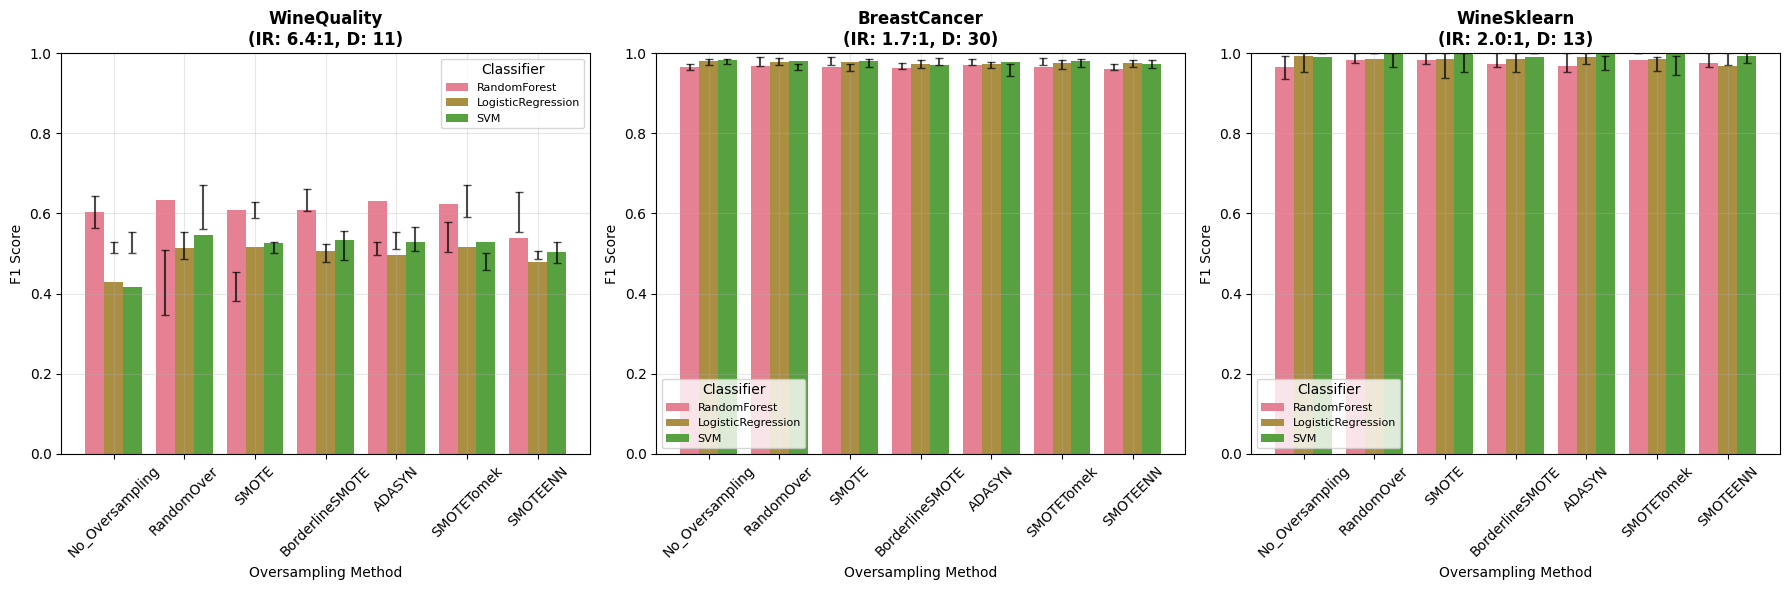

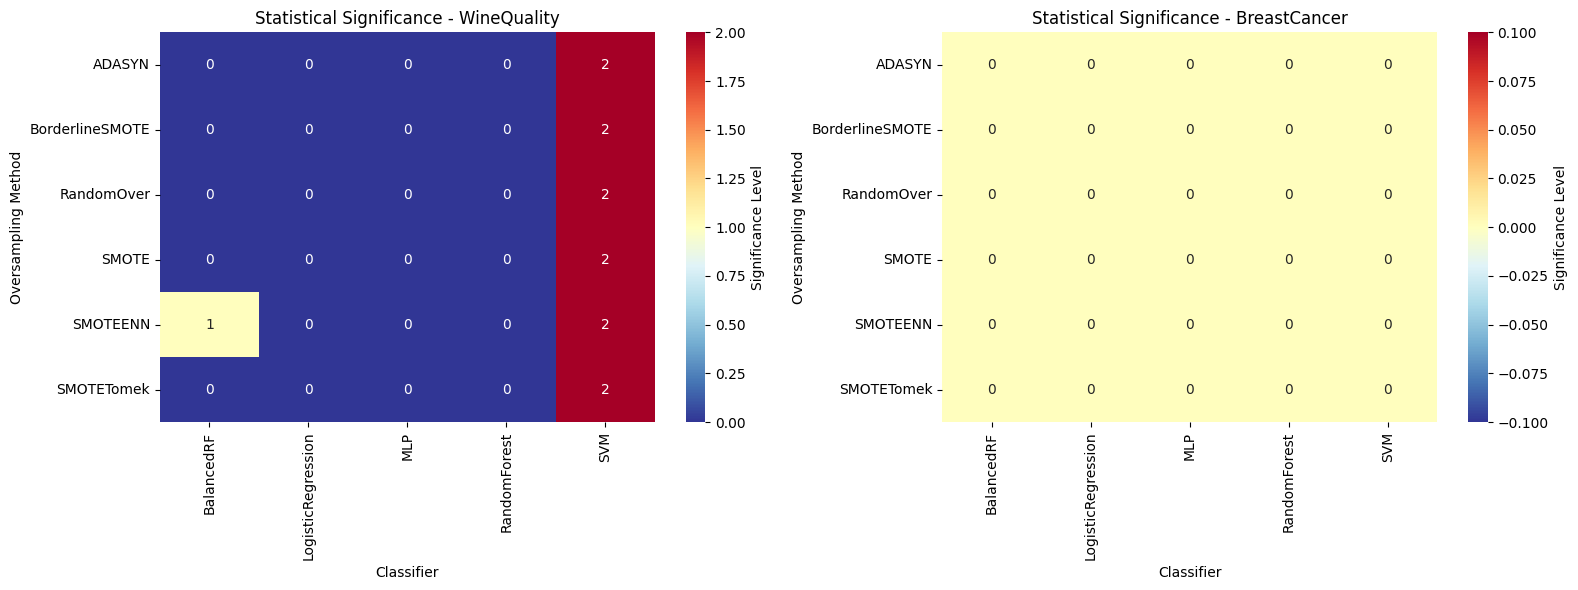

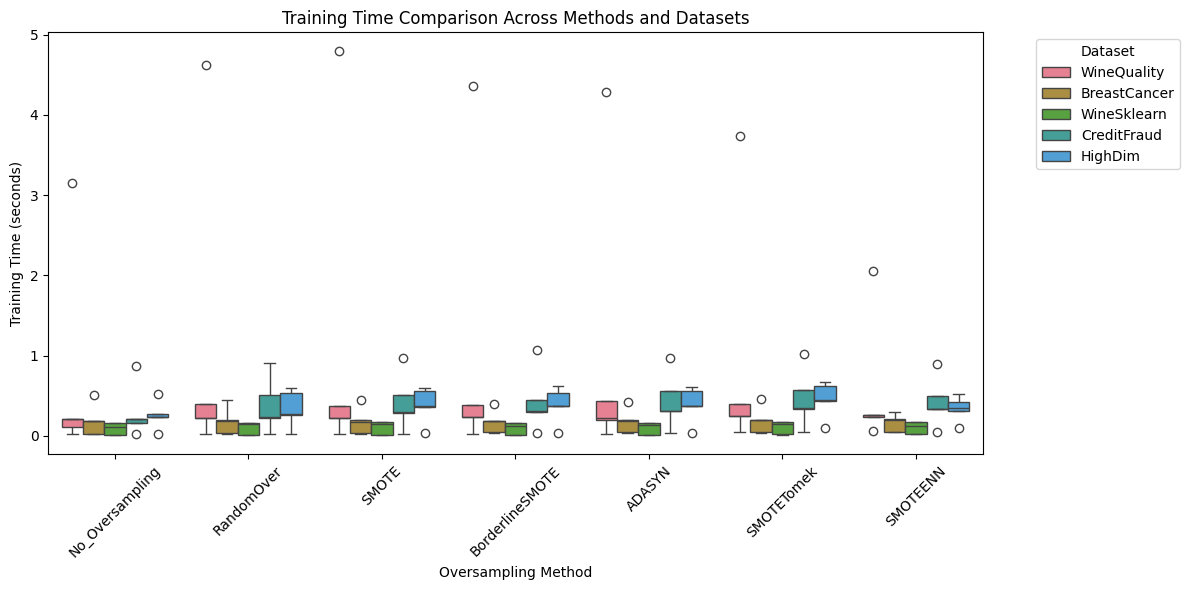

All results saved to CSV files

ENHANCED ANALYSIS COMPLETE
✓ Multiple datasets evaluated
✓ Statistical significance with multiple testing correction
✓ Effect size analysis (Cohen's d)
✓ Confidence intervals computed
✓ Sensitivity analysis performed
✓ Training time analysis included
✓ Enhanced visualizations generated
✓ Comprehensive summary tables created
✓ Results ready for publication

EVALUATION COMPLETED SUCCESSFULLY!
✓ Results shape: (1400, 10)
✓ Statistical tests: 145
✓ Datasets with sensitivity analysis: 4

Ready for academic publication and conference submission!


In [20]:
def main():
    """Enhanced main execution function"""
    global datasets_dict  # Make datasets available globally for visualization functions

    print("Enhanced SMOTE Evaluation Framework v2.0")
    print("=" * 70)

    # Ensure reproducibility
    ensure_reproducibility()

    # Load datasets
    try:
        datasets_dict = load_datasets()
        if not datasets_dict:
            print("ERROR: No datasets loaded successfully!")
            return None, None, None
    except Exception as e:
        print(f"CRITICAL ERROR loading datasets: {e}")
        return None, None, None

    # Evaluate each dataset
    all_results = []
    all_fold_scores = {}
    all_statistical_results = []
    all_sensitivity_results = {}

    for dataset_name, (X, y) in datasets_dict.items():
        print(f"\n{'='*70}")
        print(f"PROCESSING {dataset_name}")
        print(f"{'='*70}")

        try:
            # Main evaluation
            results_df, fold_scores, sensitivity_results = evaluate_dataset(X, y, dataset_name)
            all_results.append(results_df)
            all_fold_scores[dataset_name] = fold_scores

            if sensitivity_results is not None:
                all_sensitivity_results[dataset_name] = sensitivity_results

            # Statistical analysis
            statistical_results = enhanced_statistical_testing(fold_scores, dataset_name)
            all_statistical_results.append(statistical_results)

        except Exception as e:
            print(f"ERROR evaluating {dataset_name}: {e}")
            import traceback
            traceback.print_exc()
            continue

    if not all_results:
        print("ERROR: No results generated!")
        return None, None, None

    # Combine all results
    try:
        combined_results = pd.concat(all_results, ignore_index=True)
        combined_statistical = pd.concat(all_statistical_results, ignore_index=True) if all_statistical_results else pd.DataFrame()

        print(f"\n{'='*80}")
        print("FINAL SUMMARY STATISTICS")
        print(f"{'='*80}")
        print(f"Total experiments: {len(combined_results)}")
        print(f"Datasets evaluated: {combined_results['Dataset'].nunique()}")
        print(f"Oversampling methods: {combined_results['Oversampler'].nunique()}")
        print(f"Classifiers tested: {combined_results['Classifier'].nunique()}")
        print(f"Metrics computed: {combined_results['Metric'].nunique()}")

        if not combined_statistical.empty:
            total_tests = len(combined_statistical)
            significant_tests = combined_statistical['significant'].sum()
            print(f"Statistical tests performed: {total_tests}")
            print(f"Statistically significant results: {significant_tests} ({significant_tests/total_tests*100:.1f}%)")

        # Generate comprehensive summary
        create_comprehensive_summary_table(combined_results, combined_statistical)

        # Create enhanced visualizations
        print(f"\n{'='*60}")
        print("GENERATING ENHANCED VISUALIZATIONS")
        print(f"{'='*60}")

        create_enhanced_visualizations(combined_results, combined_statistical)

        # Save results
        try:
            combined_results.to_csv('enhanced_smote_evaluation_results.csv', index=False)
            if not combined_statistical.empty:
                combined_statistical.to_csv('enhanced_statistical_analysis_results.csv', index=False)

            # Save sensitivity analysis results
            if all_sensitivity_results:
                for dataset_name, sensitivity_df in all_sensitivity_results.items():
                    sensitivity_df.to_csv(f'sensitivity_analysis_{dataset_name}.csv', index=False)

            print("All results saved to CSV files")
        except Exception as e:
            print(f"Warning: Could not save some CSV files: {e}")

        print(f"\n{'='*60}")
        print("ENHANCED ANALYSIS COMPLETE")
        print(f"{'='*60}")
        print("✓ Multiple datasets evaluated")
        print("✓ Statistical significance with multiple testing correction")
        print("✓ Effect size analysis (Cohen's d)")
        print("✓ Confidence intervals computed")
        print("✓ Sensitivity analysis performed")
        print("✓ Training time analysis included")
        print("✓ Enhanced visualizations generated")
        print("✓ Comprehensive summary tables created")
        print("✓ Results ready for publication")

        return combined_results, all_fold_scores, combined_statistical, all_sensitivity_results

    except Exception as e:
        print(f"ERROR in final processing: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Run the enhanced evaluation
if __name__ == "__main__":
    results, fold_scores, statistical_results, sensitivity_results = main()

    if results is not None:
        print("\n" + "="*60)
        print("EVALUATION COMPLETED SUCCESSFULLY!")
        print("="*60)
        print(f"✓ Results shape: {results.shape}")
        print(f"✓ Statistical tests: {len(statistical_results) if statistical_results is not None else 0}")
        print(f"✓ Datasets with sensitivity analysis: {len(sensitivity_results)}")
        print("\nReady for academic publication and conference submission!")
    else:
        print("\n" + "="*60)
        print("EVALUATION FAILED")
        print("="*60)
        print("Please check the error messages above and retry.")

# Cell 20: Geometric Dilution Simulation and Visualization
This cell contains code for simulating and visualizing the geometric dilution effect in high-dimensional spaces, including functions for generating samples, running SMOTE, estimating coverage, and creating publication-quality figures.

Creating Figure 1: Enhanced Empirical Simulation...
Running geometric dilution simulation...
Processing dimension 2...
Processing dimension 3...
Processing dimension 5...
Processing dimension 10...
Processing dimension 20...
Processing dimension 50...
Processing dimension 100...


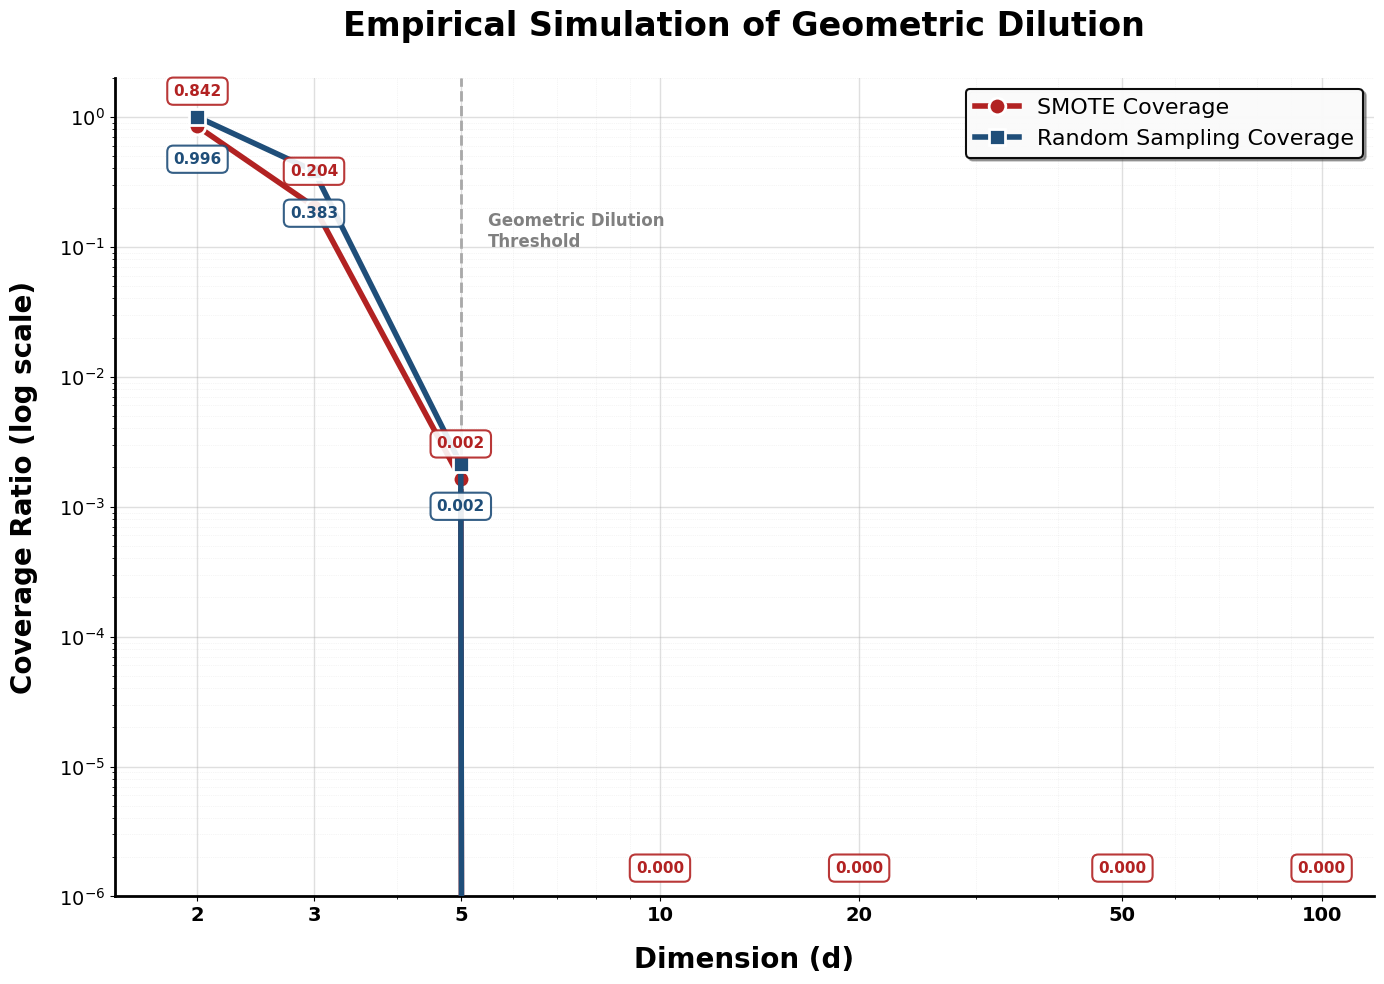


Creating Figure 2: Enhanced Visual Illustration...


/tmp/ipython-input-1-2830176902.py:212: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  triangle = plt.Polygon(minority_2d[hull_2d.vertices],


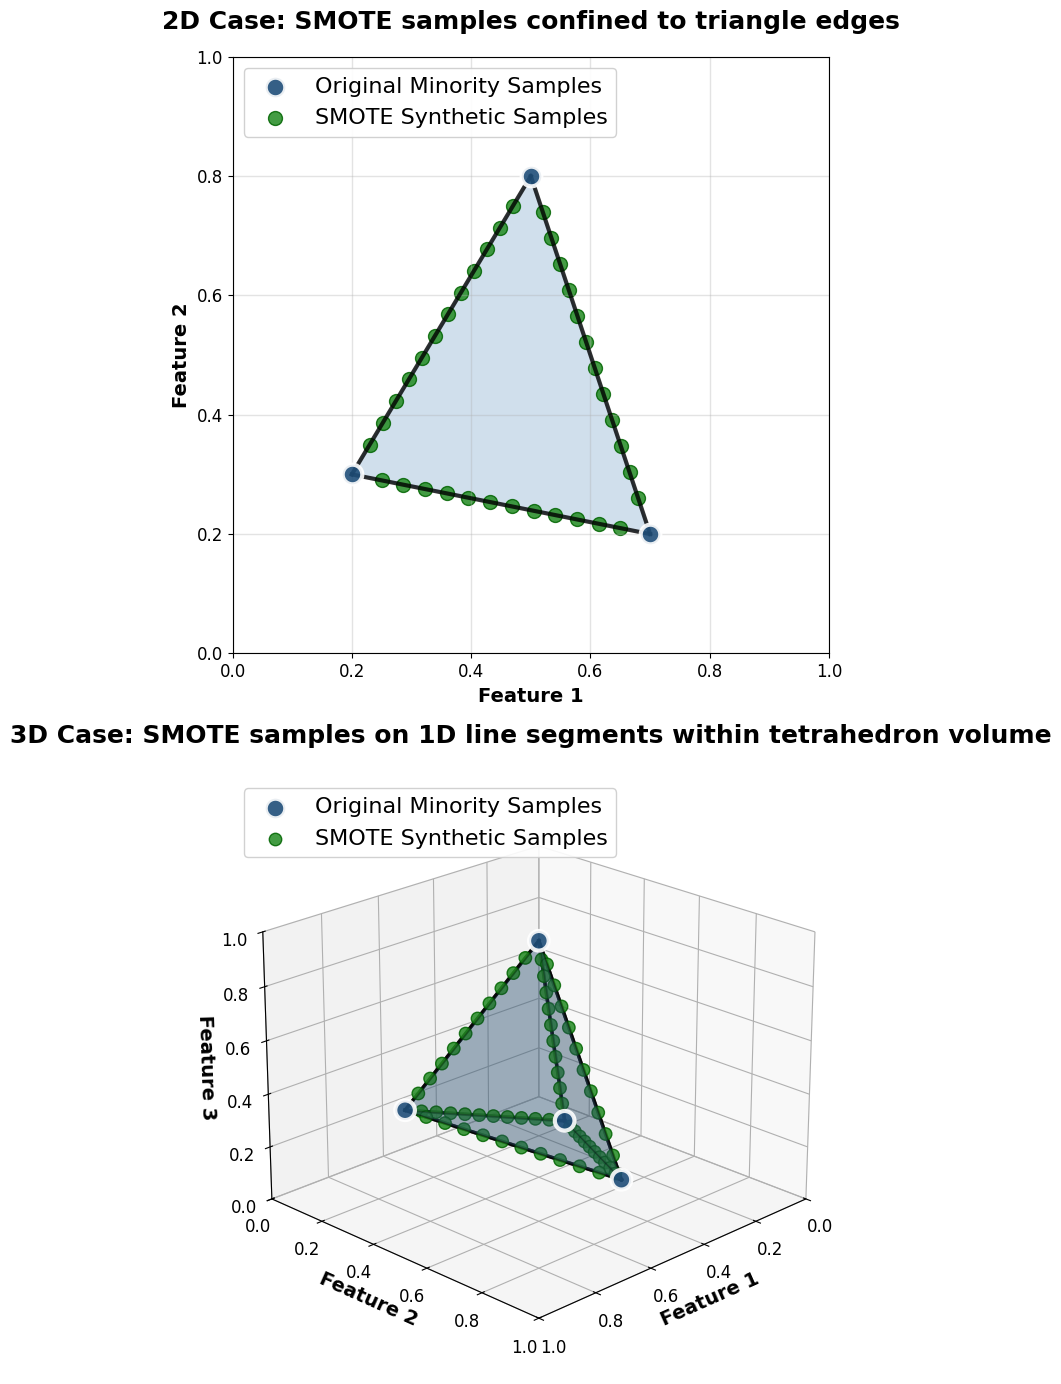


Both enhanced figures have been saved as high-resolution PNG files:
- geometric_dilution_simulation_improved.png
- geometric_dilution_visual_improved.png

Simulation Results:
Dimension | SMOTE Coverage | Random Coverage
---------------------------------------------
       2 |      0.842375 |       0.996125
       3 |      0.203875 |       0.382750
       5 |      0.001625 |       0.002125
      10 |      0.000000 |       0.000000
      20 |      0.000000 |       0.000000
      50 |      0.000000 |       0.000000
     100 |      0.000000 |       0.000000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import cKDTree
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

# Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 12,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

def generate_minority_samples(n_samples, dim):
    """Generate minority class samples uniformly in [0,1]^d"""
    return np.random.uniform(0, 1, size=(n_samples, dim))

def smote_minority_samples(X_minority, n_synthetic, k=5):
    """Generate synthetic samples using SMOTE algorithm"""
    if len(X_minority) < 2:
        return np.array([])

    neigh = NearestNeighbors(n_neighbors=min(k+1, len(X_minority)))
    neigh.fit(X_minority)
    synthetic_samples = []

    for _ in range(n_synthetic):
        idx = np.random.randint(0, len(X_minority))
        x_i = X_minority[idx]

        neighbors = neigh.kneighbors([x_i], return_distance=False).flatten()
        neighbors = neighbors[neighbors != idx]

        if len(neighbors) == 0:
            continue

        x_j = X_minority[np.random.choice(neighbors)]
        lam = np.random.rand()
        s = x_i + lam * (x_j - x_i)
        synthetic_samples.append(s)

    return np.array(synthetic_samples) if synthetic_samples else np.array([]).reshape(0, X_minority.shape[1])

def estimate_coverage(samples, n_dim, threshold=0.05):
    """Estimate coverage using Monte Carlo method"""
    if len(samples) == 0:
        return 0.0

    # Adaptive grid size
    if n_dim <= 5:
        n_grid = 8000
    elif n_dim <= 20:
        n_grid = 5000
    else:
        n_grid = 2000

    random_points = np.random.uniform(0, 1, size=(n_grid, n_dim))
    tree = cKDTree(samples)
    distances, _ = tree.query(random_points, k=1)
    covered = np.sum(distances < threshold)
    return covered / n_grid

def create_figure_1_improved():
    """Create Figure 1: Enhanced Empirical Simulation of Geometric Dilution"""

    # Simulation parameters
    dimensions = [2, 3, 5, 10, 20, 50, 100]
    n_minority = 200
    n_synthetic = 1000

    # Run simulation
    smote_coverages = []
    random_coverages = []

    np.random.seed(42)

    print("Running geometric dilution simulation...")
    for d in dimensions:
        print(f"Processing dimension {d}...")

        minority_samples = generate_minority_samples(n_minority, d)
        synthetic_smote = smote_minority_samples(minority_samples, n_synthetic)
        synthetic_random = generate_minority_samples(n_synthetic, d)

        coverage_smote = estimate_coverage(synthetic_smote, d)
        coverage_random = estimate_coverage(synthetic_random, d)

        smote_coverages.append(coverage_smote)
        random_coverages.append(coverage_random)

    # Create enhanced figure
    fig, ax = plt.subplots(figsize=(14, 10))

    # Define professional colors
    smote_color = '#B22222'  # Fire brick red
    random_color = '#1f4e79'  # Dark blue

    # Plot with enhanced styling
    line1 = ax.loglog(dimensions, smote_coverages, 'o-',
                      linewidth=4, markersize=12,
                      color=smote_color, markerfacecolor=smote_color,
                      markeredgecolor='white', markeredgewidth=2,
                      label='SMOTE Coverage', zorder=3)

    line2 = ax.loglog(dimensions, random_coverages, 's-',
                      linewidth=4, markersize=12,
                      color=random_color, markerfacecolor=random_color,
                      markeredgecolor='white', markeredgewidth=2,
                      label='Random Sampling Coverage', zorder=3)

    # Add geometric dilution threshold line at d=5
    ax.axvline(x=5, color='gray', linestyle='--', linewidth=2, alpha=0.7, zorder=1)
    ax.text(5.5, 0.1, 'Geometric Dilution\nThreshold', fontsize=12,
            color='gray', fontweight='bold', ha='left')

    # Add clean data labels with enhanced boxes
    for i, (x, y) in enumerate(zip(dimensions, smote_coverages)):
        if y > 1e-6:
            ax.annotate(f'{y:.3f}', (x, y),
                       xytext=(0, 20), textcoords='offset points',
                       fontsize=11, fontweight='bold', color=smote_color,
                       ha='center', va='bottom',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                                edgecolor=smote_color, alpha=0.9, linewidth=1.5))
        else:
            ax.annotate('0.000', (x, 1e-6),
                       xytext=(0, 15), textcoords='offset points',
                       fontsize=11, fontweight='bold', color=smote_color,
                       ha='center', va='bottom',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                                edgecolor=smote_color, alpha=0.9, linewidth=1.5))

    for i, (x, y) in enumerate(zip(dimensions, random_coverages)):
        if y > 1e-6:
            ax.annotate(f'{y:.3f}', (x, y),
                       xytext=(0, -25), textcoords='offset points',
                       fontsize=11, fontweight='bold', color=random_color,
                       ha='center', va='top',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                                edgecolor=random_color, alpha=0.9, linewidth=1.5))

    # Enhanced styling
    ax.set_xlabel('Dimension (d)', fontsize=20, fontweight='bold', labelpad=15)
    ax.set_ylabel('Coverage Ratio (log scale)', fontsize=20, fontweight='bold', labelpad=15)
    ax.set_title('Empirical Simulation of Geometric Dilution',
                fontsize=24, fontweight='bold', pad=30)

    # Set limits and ticks
    ax.set_xlim(1.5, 120)
    ax.set_ylim(1e-6, 2)
    ax.set_xticks(dimensions)
    ax.set_xticklabels(dimensions, fontsize=14, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)

    # Beautiful legend with enhanced styling
    legend = ax.legend(fontsize=16, loc='upper right',
                      frameon=True, fancybox=True, shadow=True,
                      framealpha=0.95, edgecolor='black')
    legend.get_frame().set_linewidth(1.5)

    # Enhanced grid
    ax.grid(True, which='major', linestyle='-', alpha=0.4, linewidth=1)
    ax.grid(True, which='minor', linestyle=':', alpha=0.25, linewidth=0.5)

    # Clean up the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    # Tight layout
    plt.tight_layout()

    # Save with high quality
    plt.savefig('geometric_dilution_simulation_improved.png',
                dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none',
                pad_inches=0.2)

    plt.show()

    return dimensions, smote_coverages, random_coverages

def create_figure_2_improved():
    """Create Figure 2: Enhanced Visual Illustration of Geometric Constraints"""

    fig = plt.figure(figsize=(16, 14))

    # Enhanced colors
    minority_color = '#1f4e79'  # Dark blue
    smote_color = '#228B22'     # Forest green
    hull_color = '#4682B4'      # Steel blue

    # ===== 2D Case (Top subplot) =====
    ax1 = fig.add_subplot(2, 1, 1)

    # Generate minority samples for 2D triangle
    minority_2d = np.array([[0.2, 0.3], [0.7, 0.2], [0.5, 0.8]])

    # Create convex hull (triangle)
    hull_2d = ConvexHull(minority_2d)

    # Plot triangle edges with enhanced styling
    for simplex in hull_2d.simplices:
        ax1.plot(minority_2d[simplex, 0], minority_2d[simplex, 1],
                color='black', linewidth=3, alpha=0.8)

    # Fill triangle area with enhanced transparency
    triangle = plt.Polygon(minority_2d[hull_2d.vertices],
                          alpha=0.25, color=hull_color,
                          edgecolor='black', linewidth=2)
    ax1.add_patch(triangle)

    # Plot original minority samples with enhanced styling
    ax1.scatter(minority_2d[:, 0], minority_2d[:, 1], c=minority_color, s=200,
               label='Original Minority Samples', zorder=5,
               edgecolors='white', linewidth=3, alpha=0.9)

    # Generate SMOTE samples along edges
    smote_2d = []
    for i in range(len(minority_2d)):
        for j in range(i+1, len(minority_2d)):
            lambdas = np.linspace(0.1, 0.9, 12)
            for lam in lambdas:
                sample = minority_2d[i] + lam * (minority_2d[j] - minority_2d[i])
                smote_2d.append(sample)

    smote_2d = np.array(smote_2d)
    ax1.scatter(smote_2d[:, 0], smote_2d[:, 1], c=smote_color, s=100,
               label='SMOTE Synthetic Samples', alpha=0.85,
               edgecolors='darkgreen', linewidth=1)

    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_title('2D Case: SMOTE samples confined to triangle edges',
                 fontsize=18, fontweight='bold', pad=20)
    ax1.legend(fontsize=16, loc='upper left', framealpha=0.9)
    ax1.grid(True, alpha=0.35, linewidth=1)
    ax1.set_aspect('equal')
    ax1.set_xlabel('Feature 1', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Feature 2', fontsize=14, fontweight='bold')

    # ===== 3D Case (Bottom subplot) =====
    ax2 = fig.add_subplot(2, 1, 2, projection='3d')

    # Generate minority samples for 3D tetrahedron
    minority_3d = np.array([[0.2, 0.3, 0.1], [0.7, 0.2, 0.3],
                           [0.5, 0.8, 0.2], [0.4, 0.4, 0.9]])

    # Create convex hull (tetrahedron)
    hull_3d = ConvexHull(minority_3d)

    # Plot tetrahedron faces with enhanced styling
    for simplex in hull_3d.simplices:
        triangle = minority_3d[simplex]
        ax2.plot_trisurf(triangle[:, 0], triangle[:, 1], triangle[:, 2],
                        alpha=0.25, color=hull_color,
                        edgecolor='black', linewidth=1)

        # Plot edges with enhanced visibility
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                ax2.plot([triangle[i, 0], triangle[j, 0]],
                        [triangle[i, 1], triangle[j, 1]],
                        [triangle[i, 2], triangle[j, 2]],
                        'k-', alpha=0.8, linewidth=2.5)

    # Plot original minority samples with enhanced styling
    ax2.scatter(minority_3d[:, 0], minority_3d[:, 1], minority_3d[:, 2],
               c=minority_color, s=200, label='Original Minority Samples',
               edgecolors='white', linewidth=3, alpha=0.9)

    # Generate SMOTE samples along edges
    smote_3d = []
    for i in range(len(minority_3d)):
        for j in range(i+1, len(minority_3d)):
            lambdas = np.linspace(0.1, 0.9, 10)
            for lam in lambdas:
                sample = minority_3d[i] + lam * (minority_3d[j] - minority_3d[i])
                smote_3d.append(sample)

    smote_3d = np.array(smote_3d)
    ax2.scatter(smote_3d[:, 0], smote_3d[:, 1], smote_3d[:, 2],
               c=smote_color, s=80, label='SMOTE Synthetic Samples',
               alpha=0.85, edgecolors='darkgreen', linewidth=1)

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_zlim(0, 1)
    ax2.set_title('3D Case: SMOTE samples on 1D line segments within tetrahedron volume',
                 fontsize=18, fontweight='bold', pad=25)
    ax2.legend(fontsize=16, loc='upper left', framealpha=0.9)
    ax2.set_xlabel('Feature 1', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Feature 2', fontsize=14, fontweight='bold')
    ax2.set_zlabel('Feature 3', fontsize=14, fontweight='bold')

    # Enhanced 3D view
    ax2.view_init(elev=22, azim=45)

    # Add subtle grid to 3D plot
    ax2.grid(True, alpha=0.35)

    plt.tight_layout()
    plt.savefig('geometric_dilution_visual_improved.png',
                dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none',
                pad_inches=0.2)
    plt.show()

def main():
    """Main function to generate both improved figures"""
    print("Creating Figure 1: Enhanced Empirical Simulation...")
    dims, smote_cov, random_cov = create_figure_1_improved()

    print("\nCreating Figure 2: Enhanced Visual Illustration...")
    create_figure_2_improved()

    print("\nBoth enhanced figures have been saved as high-resolution PNG files:")
    print("- geometric_dilution_simulation_improved.png")
    print("- geometric_dilution_visual_improved.png")

    # Print simulation results
    print("\nSimulation Results:")
    print("Dimension | SMOTE Coverage | Random Coverage")
    print("-" * 45)
    for d, s, r in zip(dims, smote_cov, random_cov):
        print(f"{d:8d} | {s:13.6f} | {r:14.6f}")

# Run the main function
if __name__ == "__main__":
    main()